# Anomaly Detection

The objective of this notebook is to create a reconstruction autoencoder AI model to detect ssh login intrusion.

In [87]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, callbacks
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt

sns.set(font_scale=1.4)
sns.set_style("white")
sns.set_style("ticks")

The following data is extracted from the syslog of a Linux VM on Azure. "myazure1" is a valid user that has successfully logged into the VM several times. Other users are unsuccessfully tried by the bots on the internet. Although the data is labelled, the labels are used only to validate the efficacy of the model.

The definition of the data attributes are given below
- **login_success** - Whether the SSH login is successful (1) or not (0)
- **wrong_password** - Whether the SSH password was wrong (1) or correct (0)
- **invalid_user** - Whether the SSH user is invalid (1) or valid (0)
- **last_login_success** - Whether the given user's last login was successful (1) or not (0)
- **last_ip_login_failure** - Whether the source IP and user combination failed to login last time (1) or not (0)
- **anomaly** - Whether there  is anomaly (1) or not (0). All the users tried by the bots on the internet are marked as anomaly

In [88]:
PATH_TO_DATA = 'https://raw.githubusercontent.com/saptarshibasu/anomaly-detection/main/sample-data/sshlogin_3.csv'

data = pd.read_csv(PATH_TO_DATA, header = 0)

data.head(100)

,login_success,wrong_password,invalid_user,last_login_success,last_ip_login_failure,user,source_ip,source_port,anomaly
0,0,0,1,0,0,profile1,102.22.177.9,50290,1
1,0,0,1,0,1,profile1,102.22.177.9,56554,1
2,0,0,1,0,1,profile1,102.22.177.9,51287,1
3,0,0,1,0,1,profile1,102.22.177.9,65310,1
4,0,0,1,0,0,user1,102.22.177.9,65164,1
...,...,...,...,...,...,...,...,...,...
95,0,1,0,0,0,root,138.197.180.102,35634,1
96,1,0,0,1,0,myazure1,223.191.32.164,41570,0
97,1,0,0,1,0,myazure1,223.191.32.164,41569,0
98,0,0,1,0,0,tech,49.234.5.191,52984,1


### Data Preparation

In [89]:
TARGET = 'anomaly'
USER = 'user'
SOURCE_IP = 'source_ip'
SOURCE_PORT = 'source_port'

features = data.drop([TARGET, USER, SOURCE_IP, SOURCE_PORT], axis=1) / 2
target = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)

train_index = y_train[y_train == 0].index
train_data = x_train   #.loc[train_index]
target_data = y_train   #.loc[train_index]

features.head()

,login_success,wrong_password,invalid_user,last_login_success,last_ip_login_failure
0,0.0,0.0,0.5,0.0,0.0
1,0.0,0.0,0.5,0.0,0.5
2,0.0,0.0,0.5,0.0,0.5
3,0.0,0.0,0.5,0.0,0.5
4,0.0,0.0,0.5,0.0,0.0


### Reconstruction Autoencoder Model

In [96]:
model = Sequential(
[
    Input(shape = (train_data.shape[1],)),
    Dense(5, activation=tf.nn.relu),
    Dense(3, activation=tf.nn.relu),
    Dense(5, activation=tf.nn.sigmoid)
])

opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer = opt, loss = 'mean_squared_error')

history = model.fit(train_data, train_data, 
          epochs=10,
          batch_size=200,
          shuffle=True,
          validation_split=0.3,
          callbacks=[
              callbacks.EarlyStopping(monitor="val_loss", patience=5)
          ],
        )


Epoch 1/10
2/2 [==============================] - 1s 295ms/step - loss: 0.1430 - val_loss: 0.0941
Epoch 2/10
2/2 [==============================] - 0s 56ms/step - loss: 0.0823 - val_loss: 0.0440
Epoch 3/10
2/2 [==============================] - 0s 53ms/step - loss: 0.0375 - val_loss: 0.0197
Epoch 4/10
2/2 [==============================] - 0s 70ms/step - loss: 0.0189 - val_loss: 0.0139
Epoch 5/10
2/2 [==============================] - 0s 50ms/step - loss: 0.0140 - val_loss: 0.0111
Epoch 6/10
2/2 [==============================] - 0s 50ms/step - loss: 0.0125 - val_loss: 0.0121
Epoch 7/10
2/2 [==============================] - 0s 51ms/step - loss: 0.0129 - val_loss: 0.0111
Epoch 8/10
2/2 [==============================] - 0s 50ms/step - loss: 0.0123 - val_loss: 0.0113
Epoch 9/10
2/2 [==============================] - 0s 75ms/step - loss: 0.0122 - val_loss: 0.0100
Epoch 10/10
2/2 [==============================] - 0s 57ms/step - loss: 0.0111 - val_loss: 0.0094


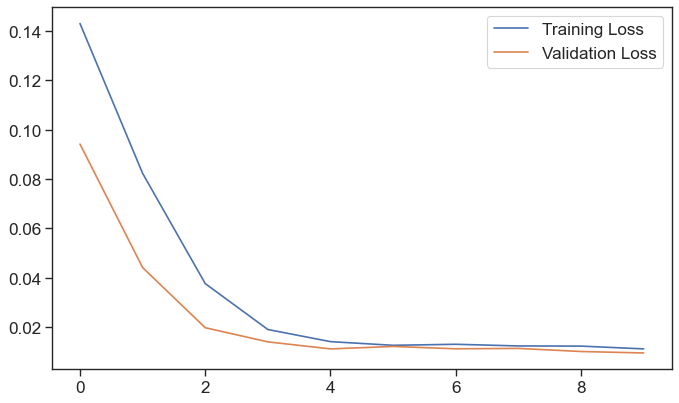

In [97]:
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

### Identify Reconstruction Error Threshold for Identifying Anomaly

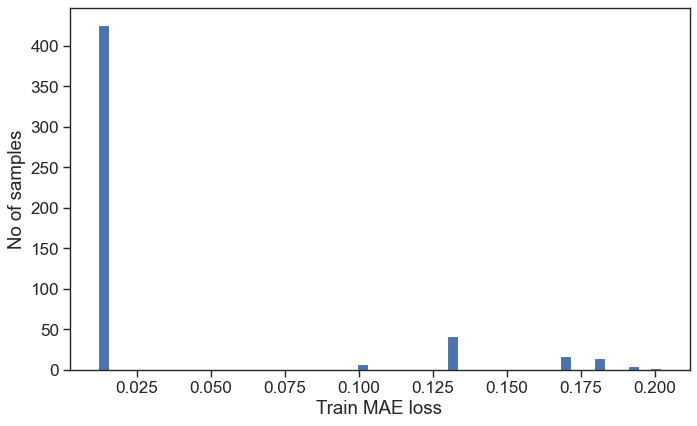

Reconstruction error threshold:  0.012


In [98]:
train_pred = model.predict(train_data)
train_mae_loss = np.mean(np.abs(train_pred - train_data), axis=1)

train_mae_loss_df = train_mae_loss.to_frame()
train_mae_loss_df.columns = ['anomaly']
train_mae_loss_counts_df = train_mae_loss_df.groupby(['anomaly']).size().reset_index(name='counts')
threshold = np.ceil(train_mae_loss_counts_df[train_mae_loss_counts_df["counts"] > 60]['anomaly'].max() * 1000) / 1000

plt.figure(figsize=(10, 6), dpi=80)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

print("Reconstruction error threshold: ", threshold)

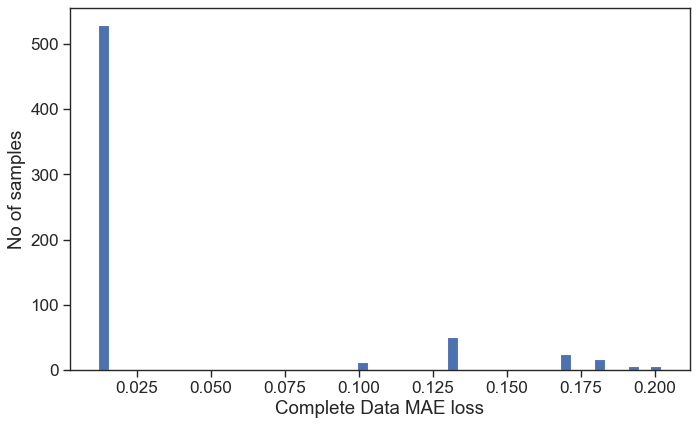

In [99]:
features_pred = model.predict(features)
features_mae_loss = np.mean(np.abs(features_pred - features), axis=1)

plt.figure(figsize=(10, 6), dpi=80)
plt.hist(features_mae_loss, bins=50)
plt.xlabel("Complete Data MAE loss")
plt.ylabel("No of samples")
plt.show()


### Mark The Record As Anomaly If Reconstruction Error Is Above Threshold

In [100]:
features_loss = features_mae_loss.to_frame()

features_loss.columns = ['anomaly']

features_loss.loc[features_loss.anomaly > threshold, "anomaly"] = 1
features_loss.loc[features_loss.anomaly <= threshold, "anomaly"] = 0

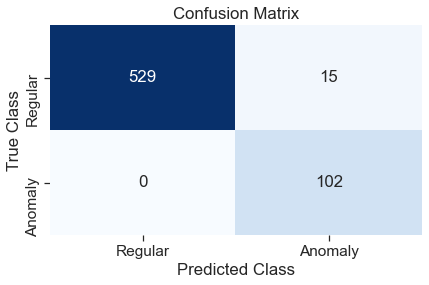

In [101]:
target.columns = ['anomaly']

matrix = confusion_matrix(target, features_loss)
confusion_df = pd.DataFrame(matrix, index = ['Regular', 'Anomaly'], columns = ['Regular', 'Anomaly'])

sns.heatmap(confusion_df, annot=True, fmt="d", cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

### View The False Positive Cases

In [102]:
indexmae = features_mae_loss[features_mae_loss>threshold].index

anomalies = data.loc[indexmae]

anomalies[anomalies['anomaly'] == 0]

,login_success,wrong_password,invalid_user,last_login_success,last_ip_login_failure,user,source_ip,source_port,anomaly
12,0,1,0,0,0,myazure1,182.66.55.189,36534,0
25,1,0,0,0,0,myazure1,223.191.32.164,51625,0
64,0,1,0,1,0,myazure1,223.191.32.164,18245,0
78,1,0,0,0,1,myazure1,223.191.32.164,3150,0
88,0,1,0,1,0,myazure1,223.191.32.164,37394,0
89,1,0,0,0,1,myazure1,223.191.32.164,51287,0
162,0,1,0,1,0,myazure1,223.191.32.164,46984,0
163,1,0,0,0,1,myazure1,223.191.32.164,3145,0
222,0,1,0,1,0,myazure1,223.191.32.164,46988,0
223,1,0,0,0,1,myazure1,223.191.32.164,40086,0
